In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time
import pickle

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *
from HN_decomposition.Subspace.PQMF import *

def RMS(x):
        return np.std(x)

figsize = (9/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

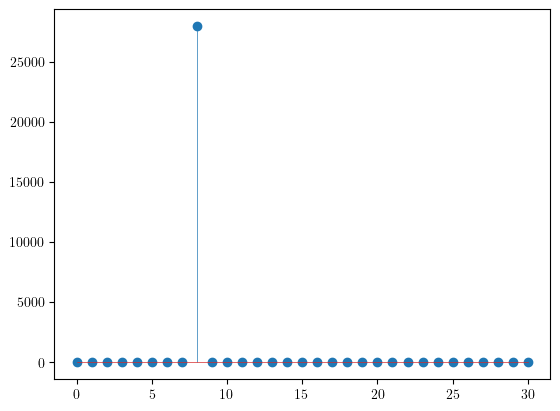

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_1_P_2.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


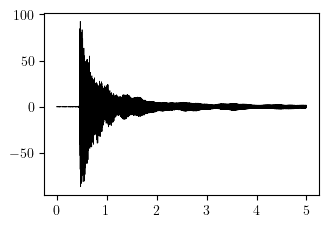

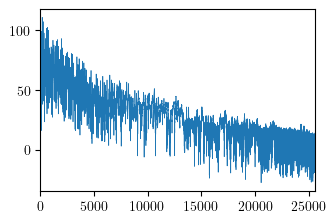

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM',
    'Medium_1', 'Corde_Acier', 'C_1_P_2.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

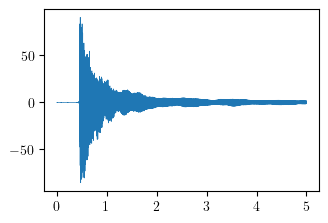

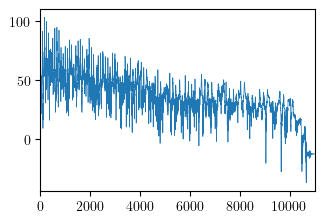

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

## Harmonic+Noise Decomposition

8


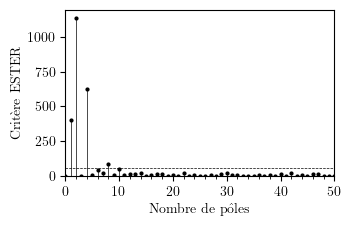

In [7]:
start_idx = np.argmax(np.abs(sig.hilbert(x)))
factor = 20

## Computations
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 200,
    rankFilter_rank = .3,
    ARFilter_length = 18,
)

num_poles, J_list = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=512,
    max_poles = 50,
    factor = factor
)

save_folder = os.path.join("..", "..", "PAM_overleaf", "Rapport_Final", "High_res", "ESTER", "Figures")
print(num_poles)
plt.figure(figsize=figsize)
markerline, stemline, baseline = plt.stem(J_list, 'k')
plt.setp(markerline, markersize = 2)
plt.axhline(np.amax(J_list)/factor, linestyle = '--', color = 'k')
plt.xlabel('Nombre de pôles')
plt.ylabel('Critère ESTER')
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'ESTER.pdf'))
plt.xlim(0,50)
plt.ylim(0)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', left = False)
plt.show()

## Filter Bank Design

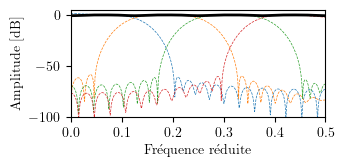

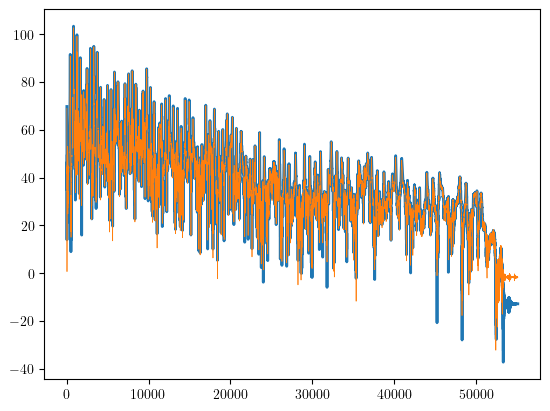

In [8]:

num_bands = 4
num_taps = num_bands*8 - 1
tol_transitionBand = .3/num_bands

x_test = np.zeros(2048)
x_test[0] = 1

Analysis_filters, Synthesis_filters = nearPR_CMFB(
    num_bands = num_bands,
    num_taps = num_taps,
    tol_transitionBand=tol_transitionBand)
## Plotting
save_folder = os.path.join(
    "..", "..", "PAM_overleaf", "Rapport_Final", "High_res", "Preprocessing", "Figures")
n_fft = 2048
xRecons = np.zeros(len(x_test))

for band_idx in range(num_bands):
    xFilter = sig.lfilter(Analysis_filters[band_idx], [1], x_test)
    xInsert = np.zeros(len(x_test))
    xInsert[::num_bands] = xFilter[::num_bands]*num_bands
    xRecons+=sig.lfilter(Synthesis_filters[band_idx], [1], xInsert)


f = np.fft.rfftfreq(n_fft, 1)
plt.figure(figsize = (9/cm, 4.5/cm))
for band_idx in range(num_bands):
    plt.plot(f, dB20(np.fft.rfft(Analysis_filters[band_idx], n = n_fft)), '--')
plt.plot(f, dB20(np.fft.rfft(xRecons)), 'k', linewidth = 2)
plt.xlim(0,.5)
plt.ylim(-100, 5)
plt.ylabel('Amplitude [dB]')
plt.xlabel("Fréquence réduite")
plt.tight_layout()
plt.savefig(
    fname = os.path.join(save_folder, "filterBank.pdf"),
    bbox_inches = 'tight'
)
plt.show()

xRecons = np.zeros(len(x))
for band_idx in range(num_bands):
    xFilter = sig.lfilter(Analysis_filters[band_idx], [1], x)
    xInsert = np.zeros(len(x))
    xInsert[::num_bands] = xFilter[::num_bands]*num_bands
    xRecons+=sig.lfilter(Synthesis_filters[band_idx], [1], xInsert)

plt.plot(dB20(np.fft.rfft(x)), linewidth = 2)
plt.plot(dB20(np.fft.rfft(xRecons)))
plt.show()
display(Audio(data = x, rate = sr_hz))
display(Audio(data = xRecons, rate = sr_hz))


Processing time : 11.31s


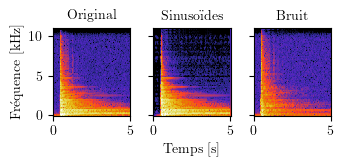

22050


In [9]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

## Initializing output vectors

## Computations
tic = time.time()
xHarmo, xNoise = multiband_HN(
    x,
    tracking_method = 'FAPI',
    num_bands = num_bands,
    ester_factor=ester_factor,
    window_length=window_length,
    hop_length=hop_length,
    FAPI_beta = .95)

toc = time.time()

print(f'Processing time : {round(toc-tic, 2)}s')

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (9/cm, 4.5/cm))
save_folder = os.path.join(
    '..','..','PAM_overleaf', 'Rapport_Final', "High_res", "HN", "Figures"
)
cmap = 'CMRmap'
#cmap = 'gray_r'
vmin = -60
vmax = 0
f, t, x_stft = sig.stft(np.real(x), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[0].pcolormesh(
    t, f, dB10(x_stft), cmap = cmap, rasterized = True,
    vmin = vmin, vmax = vmax)
ax[0].set_title("Original", fontdict={'fontsize':10})
ax[0].set_ylabel("Fréquence [kHz]")
ax[0].set_yticks([0, 5000, 10000])
ax[0].set_yticklabels(['0', '5', '10'])
#ax[0].set_xlabel("Temps [s]")
f, t, x_stft = sig.stft(np.real(xHarmo), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[1].pcolormesh(
    t, f, dB10(x_stft), cmap = cmap, rasterized = True,
    vmin = vmin, vmax = vmax)
ax[1].set_title("Sinusoïdes", fontdict={'fontsize':10})
ax[1].set_xlabel("Temps [s]")
f, t, x_stft = sig.stft(np.real(xNoise), fs = sr_hz, return_onesided=True, scaling = 'psd')
im2 = ax[2].pcolormesh(
    t, f, dB10(x_stft), cmap = cmap, rasterized = True,
    vmin = vmin, vmax = vmax)
ax[2].set_title("Bruit", fontdict={'fontsize':10})
#ax[2].set_xlabel("Temps [s]")


plt.tight_layout()

plt.savefig(os.path.join(save_folder, 'spectrogrammesHN.pdf'), bbox_inches = 'tight')
plt.show()


save_dict = {
    "input" : x,
    "harmonic" : xHarmo,
    "noise" : xNoise,
    "sampleRate" : sr_hz
}

with open("test_HN.pickle", "wb") as file:
    pickle.dump(save_dict, file, pickle.HIGHEST_PROTOCOL)

print(sr_hz)
#scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(x))
#scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(np.real(xHarmo)))
#scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(np.real(xNoise)))

In [23]:
def compute_spectralCentroid(x_fft, f):
    x_fft_norm = x_fft/(np.sum(np.abs(x_fft)))
    return np.sum(np.abs(x_fft_norm)*f)/np.sum(np.abs(x_fft_norm))

def compute_spectralBandwidth(x_fft, f, order, centroid = None):
    """
    from [1, p.135]

    References :
    ------------
    [1] Klapuri, Anssi, and Manuel Davy, eds. Signal Processing Methods for
    Music Transcription. New York: Springer, 2006.
    """
    if centroid == None:
        centroid = compute_spectralCentroid(x_fft, f)
    
    x_fft_norm = x_fft/(np.sum(np.abs(x_fft)))

    return np.power(np.sum(np.abs(x_fft_norm)*np.power(np.abs(f-centroid), order)), 1/order)

def compute_RMS(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_ZCR(x):
    crossings = 0
    for i in range(len(x)-1):
        if x[i+1]*x[i]<0:
            crossings+=1
    return crossings/len(x)
    

In [45]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

## Initializing output vectors

## Computations
xHarmo, xNoise = multiband_HN(
    x,
    tracking_method = 'FAPI',
    num_bands = num_bands,
    ester_factor=ester_factor,
    window_length=window_length,
    hop_length=hop_length,
    FAPI_beta = .95)


folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384


plt.figure(figsize = figsize)
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            print('x')

            xHarmo, x = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            x_fft = np.fft.rfft(x)
            f = np.fft.rfftfreq(len(x), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 4, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    plt.plot(RMS_list, ZCR_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 4)
    plt.xlabel('RMS')
    plt.ylabel('ZCR')
plt.legend(prop = {'size' : 8})
plt.show()

            

ValueError: x must be real.

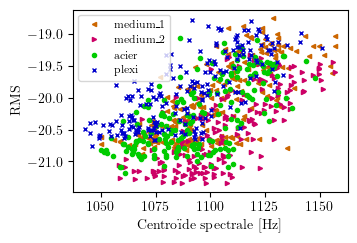

In [34]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Dataset_1')

list_tables = ['medium_1', 'medium_2', 'acier', 'plexi']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384


plt.figure(figsize = figsize)
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    for sample_idx in range(200):
        file_name = os.path.join(
            folder_mesures,
            table_str,
            'Wav',
            str(sample_idx) + '.wav'
        )
        sr_hz_old, x = scipy.io.wavfile.read(file_name)
        
        #x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
        t = np.arange(len(x))/sr_hz

        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr_hz)

        spectral_centroid = compute_spectralCentroid(
            x_fft, f)
        spectral_bandwidth = compute_spectralBandwidth(
            x_fft, f, order = 4, centroid = spectral_centroid)
        RMS = compute_RMS(x)

        centroid_list.append(spectral_centroid)
        bandwidth_list.append(spectral_bandwidth)
        RMS_list.append(dB20(RMS))
    plt.plot(centroid_list, RMS_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 3)
    plt.xlabel('Centroïde spectrale [Hz]')
    plt.ylabel('RMS')
plt.legend(prop = {'size' : 8})
plt.show()

            

In [30]:
4096*4

16384